# **5. Pytorch TensorBoard Support**

In [ ]:
# 파이토치 모델 구성 및 학습에 필요한 기본 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 이미지 데이터셋과 전처리 관련 모듈
import torchvision
import torchvision.transforms as transforms

# 시각화를 위한 matplotlib 및 numpy
import matplotlib.pyplot as plt
import numpy as np

# 텐서보드 기록용 모듈
from torch.utils.tensorboard import SummaryWriter

# Showing Images in TensorBoard

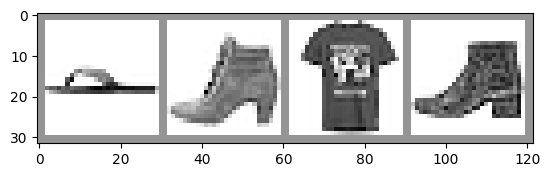

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# train 과 test 데이터셋을 다운로드하고 data 폴더에 저장
training_set = torchvision.datasets.FashionMNIST(
    'data',
    download=True,
    train=True,
    transform = transform
)
validation_set = torchvision.datasets.FashionMNIST(
    'data',
    download=True,
    train=False,
    transform = transform
)

# dataloader 생성, batch_size 4, 훈련데이터만 셔플
training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size = 4,
    shuffle = True,
    num_workers = 2
)
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = 4,
    shuffle = False,
    num_workers = 2
)

# 클래스 레이블 정의
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 시각화 하기 위한 작업
def matplotlib_imshow(img, one_channel = False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap='Greys')
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [ ]:
# 텐서보드 writer 생성
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# 이미지를 텐서보드에 기록
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush() # 즉시 디스크에 기록

# Graphing Scalars to Visualize Training

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [ ]:
print(len(validation_loader)) # validation 세트 미니배치 개수
for epoch in range(1): # 1에폭
  running_loss = 0.0

  for i, data in enumerate(training_loader, 0):
    # 입력과 정답
    inputs, labels = data

    # 기울기 초기화
    optimizer.zero_grad()

    # forward 와 손실 계산
    outputs = net(inputs)
    loss = criterion(outputs, labels)

    # 역전파와 파라미터 갱신
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # 1000배치마다 손실 기록
    if i % 1000 == 990:
      print('Batch {}'.format(i + 1))
      running_vloss = 0.0

      net.train(False) # evaluation 모드
      for j, vdata in enumerate(validation_loader, 0):
        vinputs, vlabels = vdata
        voutputs = net(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss.item()
      net.train(True) # 다시 train 모드

      avg_loss = running_loss / 1000
      avg_vloss = running_vloss / len(validation_loader)

      writer.add_scalars('Training vs. Validatiaon Loss',
                         { 'Training ' : avg_loss, 'Validation' : avg_vloss},
                         epoch * len(training_loader) + i)

      running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 991
Batch 1991
Batch 2991
Batch 3991
Batch 4991
Batch 5991
Batch 6991
Batch 7991
Batch 8991
Batch 9991
Batch 10991
Batch 11991
Batch 12991
Batch 13991
Batch 14991
Finished Training


# Visualizing your Model

In [ ]:
dataiter = iter(training_loader)
imags, labels = next(dataiter)

# add_graph()를 사용하면 샘플 입력을 따라 모델의 연산 그래프를 자동을으로 그려줌
# 텐서 보드의 graphs 탭에서 net 노드를 더블 클릭하면 층별 데이터 흐름이 전개될거임
writer.add_graph(net, images)
writer.flush()

# Visualizing Your Dataset with Embeddings

In [ ]:
def select_n_random(data, labels, n=100):
  assert len(data) == len(labels)

  perm = torch.randperm(len(data)) # 무작위 순열
  return data[perm][:n], labels[perm][:n]

# 샘플 이미지와 레이블 추출
images, labels = select_n_random(training_set.data, training_set.targets)

# 레이블 문자열로 변환
class_labels = [classes[label] for label in labels]

features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata = class_labels,
                     label_img = images.unsqueeze(1))
writer.flush()
writer.close()